In [1]:
import pandas as pd
from  pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import gc
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
import random

In [2]:
df_train = pd.read_csv('train.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')
df_merchant= pd.read_csv('merchants.csv')

### EDA_Train_DataSet

In [3]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
df_train.shape

(201917, 6)

In [5]:
df_train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

#### Reduce Storage

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
df_train=reduce_mem_usage(df_train)

Mem. usage decreased to  4.04 Mb (56.2% reduction)


#### Convert Str to Date

In [8]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])

#### Target Value Distribution

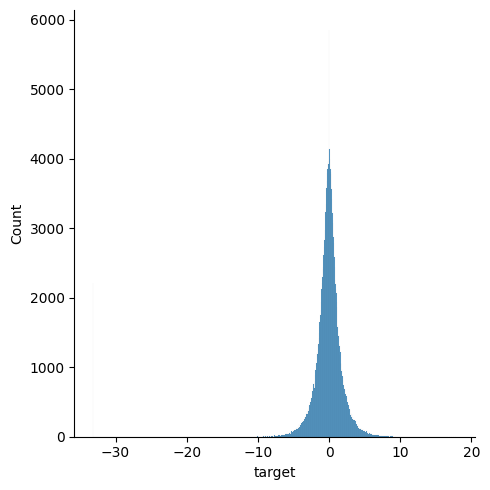

In [9]:
sns.displot(df_train, x="target")

<Axes: xlabel='target'>

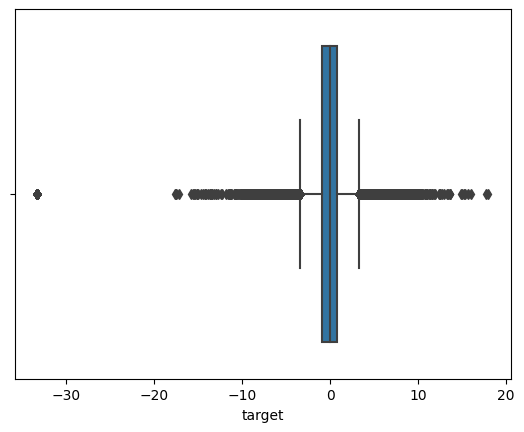

In [10]:
sns.boxplot(x=df_train['target'])

In [11]:
train_outlier=df_train[df_train['target']<-30]

In [12]:
round((train_outlier.shape[0]/df_train.shape[0])*100,2)

1.09

Since 1.09% of our data has target value below -30 so we cant consider this as an outlier. for now we will consider as a rare data point.

In [13]:
train_witout_outlier=df_train[~(df_train['target']<-30)]

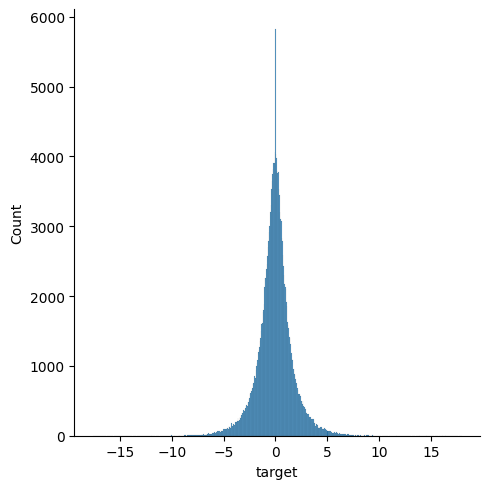

In [14]:
sns.displot(train_witout_outlier, x="target")

<Axes: xlabel='feature_3', ylabel='count'>

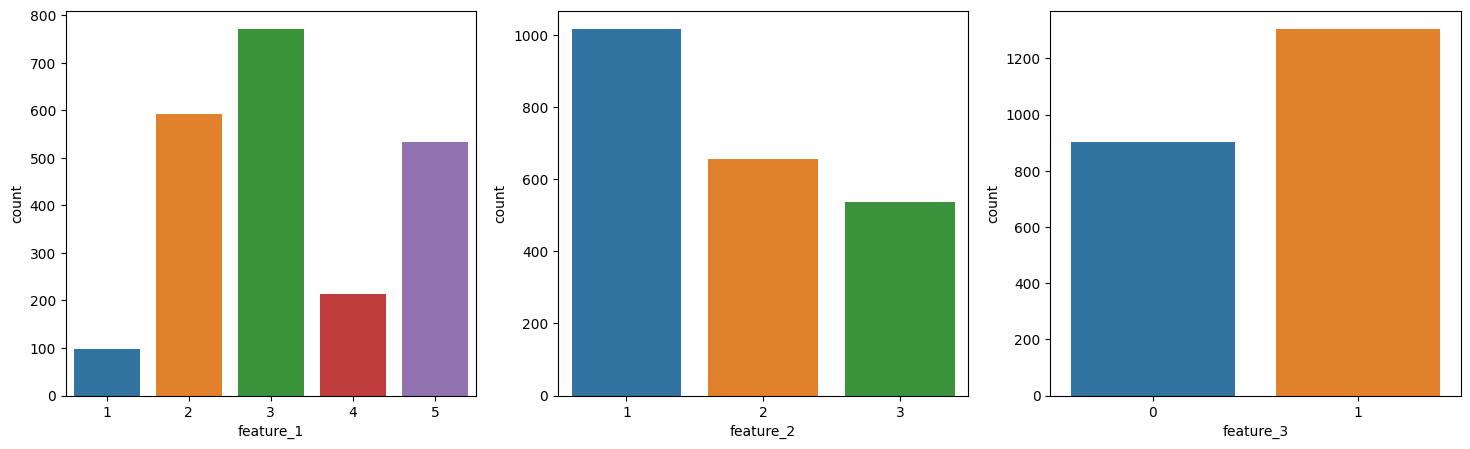

In [15]:
fig,ax=plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(ax=ax[0],data=train_outlier,x='feature_1')
sns.countplot(ax=ax[1],data=train_outlier,x='feature_2')
sns.countplot(ax=ax[2],data=train_outlier,x='feature_3')

<Axes: xlabel='feature_3', ylabel='count'>

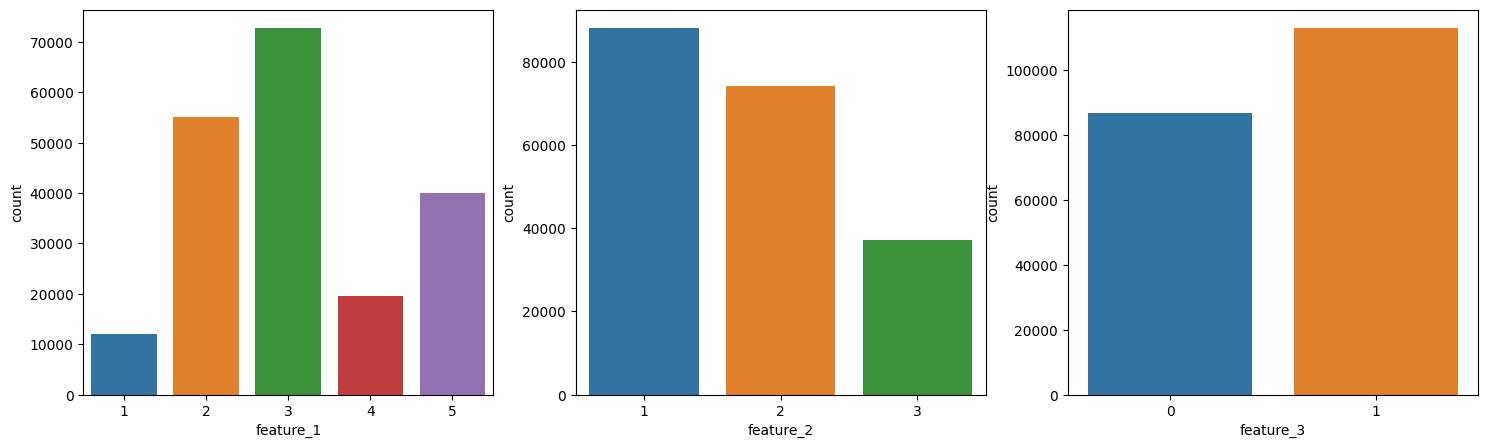

In [16]:
fig,ax=plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(ax=ax[0],data=train_witout_outlier,x='feature_1')
sns.countplot(ax=ax[1],data=train_witout_outlier,x='feature_2')
sns.countplot(ax=ax[2],data=train_witout_outlier,x='feature_3')

There is not much difference between the features 1,2 and 3 for rare and non rare data points. Extracting features from historical transactions and merchant transactions might be helpful to better predict these rare loyalty scores of <-30

#### Calculate Recency 

In [17]:
max_date =pd.to_datetime(max(df_train['first_active_month']))
max_date

Timestamp('2018-02-01 00:00:00')

In [18]:
df_train['Recency'] = df_train['first_active_month'].apply(lambda x:(max_date-x).days)

In [19]:
df_train['Recency'] = df_train['Recency']//30

In [20]:
df_train['Recency'] 

0          8
1         13
2         18
3          5
4          3
          ..
201912     5
201913    28
201914     6
201915    19
201916     7
Name: Recency, Length: 201917, dtype: int64

In [21]:
train_witout_outlier=df_train[~(df_train['target']<-30)]

<Axes: xlabel='Recency', ylabel='target'>

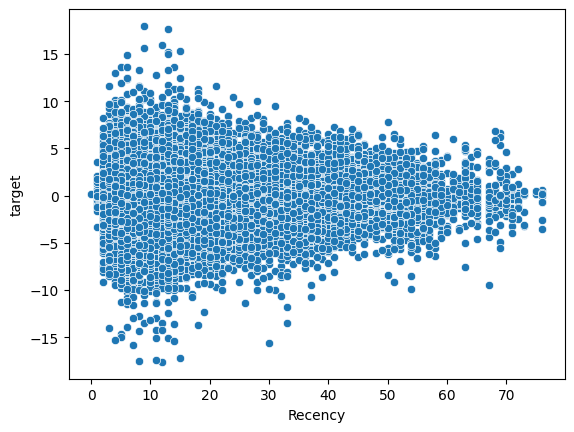

In [22]:
sns.scatterplot(x=train_witout_outlier['Recency'], y=train_witout_outlier['target'])

We can observe a trend here that the most recent have higher loyalty scores.

However, this also shows that there are more number of recent users as compared to long time users.

### EDA_Historical_Transactions

In [23]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [24]:
df_hist_trans=reduce_mem_usage(df_hist_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


#### Imputing Null values

In [25]:
df_hist_trans.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [26]:
df_hist_trans.category_2.fillna(df_hist_trans.category_2.mode()[0],inplace=True)
df_hist_trans.category_3.fillna(df_hist_trans.category_3.mode()[0],inplace=True)
df_hist_trans.merchant_id.fillna(df_hist_trans.merchant_id.mode()[0],inplace=True)

#### Convert Str to Date

In [27]:
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])

In [28]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

df_hist_trans=binarize(df_hist_trans)

In [29]:
def cat_to_num(df):
    df['category_3'] = df['category_3'].map({'A':1, 'B':2,'C':3})
    return df

df_hist_trans=cat_to_num(df_hist_trans)

In [30]:
df_hist_trans=reduce_mem_usage(df_hist_trans)

Mem. usage decreased to 1166.08 Mb (33.3% reduction)


#### Removing Test dataset user from train dataset

In [31]:
df_hist_trans=df_hist_trans[df_hist_trans.card_id.isin(df_train.card_id)]

In [32]:
len(df_hist_trans.card_id.unique()),len(df_train.card_id.unique())

(201917, 201917)

In [33]:
df_hist_trans

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
400,0,C_ID_5037ff576e,322,0,1,2,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
401,1,C_ID_5037ff576e,138,0,1,2,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
402,1,C_ID_5037ff576e,138,0,1,2,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33
403,1,C_ID_5037ff576e,226,0,1,2,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19
404,1,C_ID_5037ff576e,330,0,1,2,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112356,1,C_ID_2863d2fa95,-1,1,1,2,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,1.0,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,2,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,1.0,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,1,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,1,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9


<Axes: xlabel='authorized_flag', ylabel='count'>

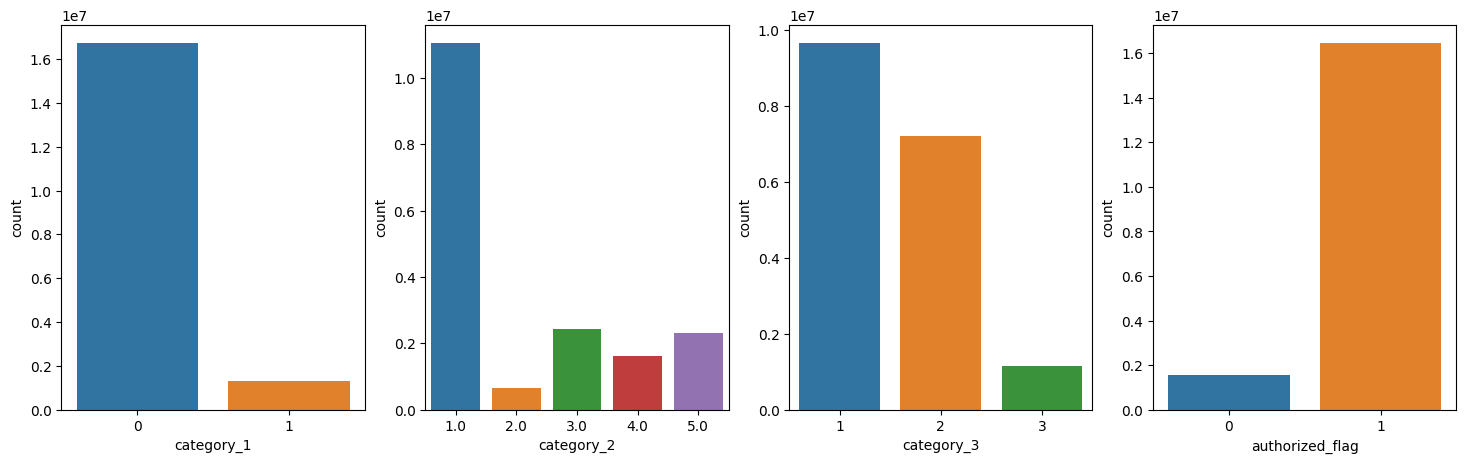

In [34]:
fig,ax=plt.subplots(1, 4, figsize=(18, 5))
sns.countplot(ax=ax[0],data=df_hist_trans, x="category_1")
sns.countplot(ax=ax[1],data=df_hist_trans, x="category_2")
sns.countplot(ax=ax[2],data=df_hist_trans, x="category_3")
sns.countplot(ax=ax[3],data=df_hist_trans, x="authorized_flag")

<Axes: xlabel='installments', ylabel='count'>

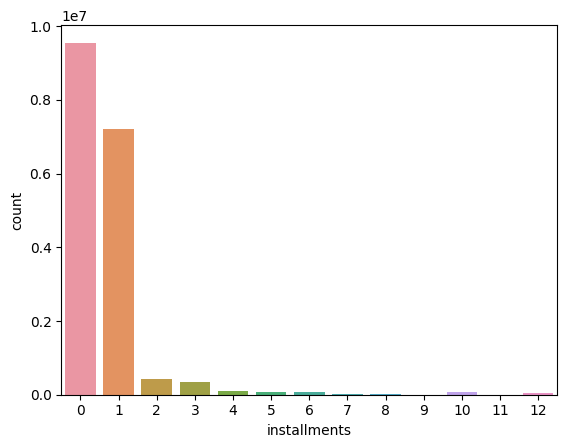

In [60]:
sns.countplot(data=df_hist_trans,x='installments')

Values of -1 and 999 seem odd for the installments.We need to remove these.

In [59]:
df_hist_trans=df_hist_trans[~df_hist_trans['installments'].isin([-1,999])]

In [36]:
df_hist_trans.purchase_amount.value_counts()

-0.671775    424400
-0.716855    374123
-0.701828    317293
-0.731881    258519
-0.596643    240952
              ...  
 3.198558         1
 3.048609         1
 6.507081         1
 0.366812         1
 2.370177         1
Name: purchase_amount, Length: 179316, dtype: int64

In [37]:
df_hist_trans.purchase_amount.max(),df_hist_trans.purchase_amount.min()

(6010604.0, -0.7469077706336975)

Maximum value is definitely an outlier. We would have to remove that.

In [38]:
df_hist_trans.month_lag.value_counts()

-2     2389787
-1     2248468
 0     2151419
-3     1920958
-4     1635925
-5     1466671
-6     1271559
-7     1098685
-8      882416
-9      761224
-10     668862
-11     620200
-12     488207
-13     425628
Name: month_lag, dtype: int64

In [39]:
df_hist_trans['category_1'].value_counts()

0    16741908
1     1288101
Name: category_1, dtype: int64

In [40]:
df_hist_trans['category_2'].value_counts()

1.0    11054945
3.0     2426416
5.0     2295169
4.0     1617762
2.0      635717
Name: category_2, dtype: int64

In [41]:
df_hist_trans['category_3'].value_counts()

1    9662719
2    7222525
3    1144765
Name: category_3, dtype: int64

### EDA_New_merchant_transactions

In [42]:
df_new_merchant_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [43]:
df_new_merchant_trans=reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [44]:
df_new_merchant_trans.isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [45]:
df_new_merchant_trans.category_2.fillna(df_new_merchant_trans.category_2.mode()[0],inplace=True)
df_new_merchant_trans.category_3.fillna(df_new_merchant_trans.category_3.mode()[0],inplace=True)
df_new_merchant_trans.merchant_id.fillna(df_new_merchant_trans.merchant_id.mode()[0],inplace=True)

#### Convert Str to Date

In [46]:
df_new_merchant_trans['purchase_date'] = pd.to_datetime(df_new_merchant_trans['purchase_date'])

#### Convert Categorical values to Numerical

In [47]:
df_new_merchant_trans=binarize(df_new_merchant_trans)

In [48]:
df_new_merchant_trans=cat_to_num(df_new_merchant_trans)

In [49]:
df_new_merchant_trans.category_1.value_counts()

0    1899935
1      63096
Name: category_1, dtype: int64

In [50]:
df_new_merchant_trans.category_3.value_counts()

1    978166
2    836178
3    148687
Name: category_3, dtype: int64

In [51]:
df_new_merchant_trans['authorized_flag'].value_counts()

1    1963031
Name: authorized_flag, dtype: int64

In [52]:
df_new_merchant_trans['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

#### Removing Test dataset user

In [53]:
df_new_merchant_trans=df_new_merchant_trans[df_new_merchant_trans.card_id.isin(df_train.card_id)]

<Axes: xlabel='installments', ylabel='count'>

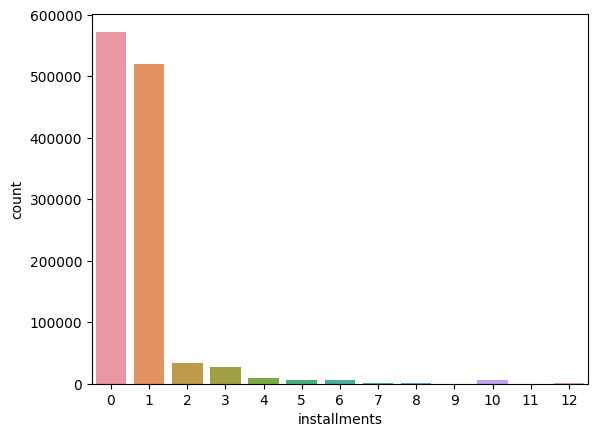

In [58]:
sns.countplot(data=df_new_merchant_trans,x='installments')

Values of -1 and 999 seem odd for the installments.We need to remove these.

In [56]:
df_new_merchant_trans=df_new_merchant_trans[~df_new_merchant_trans['installments'].isin([-1,999])]

<Axes: xlabel='authorized_flag', ylabel='count'>

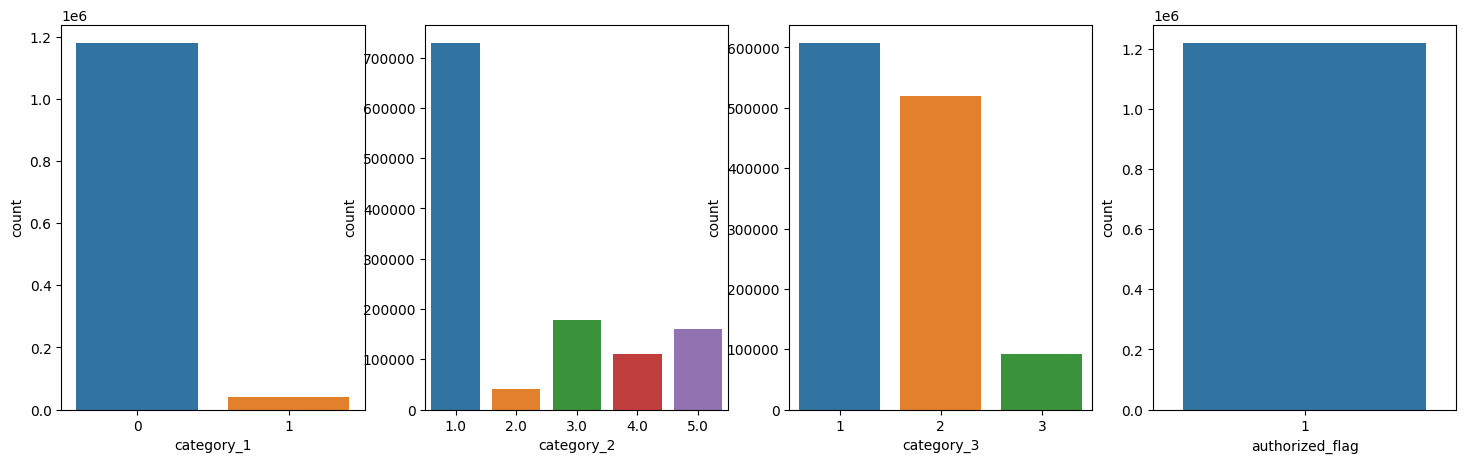

In [55]:
fig,ax=plt.subplots(1, 4, figsize=(18, 5))
sns.countplot(ax=ax[0],data=df_new_merchant_trans, x="category_1")
sns.countplot(ax=ax[1],data=df_new_merchant_trans, x="category_2")
sns.countplot(ax=ax[2],data=df_new_merchant_trans, x="category_3")
sns.countplot(ax=ax[3],data=df_new_merchant_trans, x="authorized_flag")

In [61]:
df=pd.concat([df_hist_trans, df_new_merchant_trans], ignore_index=True, axis=0)

In [62]:
df=pd.merge(df, df_train, how='left', on='card_id', suffixes=('_x', '_y'))

In [64]:
len(df.card_id.unique()),len(df_train.card_id.unique())

(201917, 201917)

### Feature Engineering

In [65]:
aggs = {}

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['authorized_flag'] = ['sum', 'mean','median']
aggs['category_1'] = ['sum', 'mean','median']
aggs['card_id'] = ['size']
aggs['category_3'] = ['sum', 'mean','median']
aggs['category_2'] = ['sum', 'mean','median']

new_columns =[ i + '_' + val for i in aggs.keys() for val in aggs[i]]

In [66]:
df_train_new=df.groupby(['card_id']).agg(aggs)

In [67]:
df_train_new.columns = new_columns
df_train_new=df_train_new.reset_index()

In [68]:
max_date =pd.to_datetime(max(df['purchase_date']))
max_date

Timestamp('2018-04-30 23:59:59')

In [69]:
df_train_new['purchase_date_max']=pd.to_datetime(df_train_new['purchase_date_max'])
df_train_new['Recency'] = df_train_new['purchase_date_max'].apply(lambda x:(max_date-x).days)
df_train_new['AOV']=df_train_new['purchase_amount_sum']/df_train_new['card_id_size']
df_train_new['Predictive_CLV'] = df_train_new['AOV']*df_train_new['card_id_size']*df_train_new['purchase_amount_sum'] 

In [70]:
df_train_new=df_train_new.merge(df_train,on='card_id')

In [71]:
df_train_new['first_active_month']=pd.to_datetime(df_train_new['first_active_month'])

In [72]:
df_train_new['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train_new['first_active_month'].dt.date).dt.days

<Axes: >

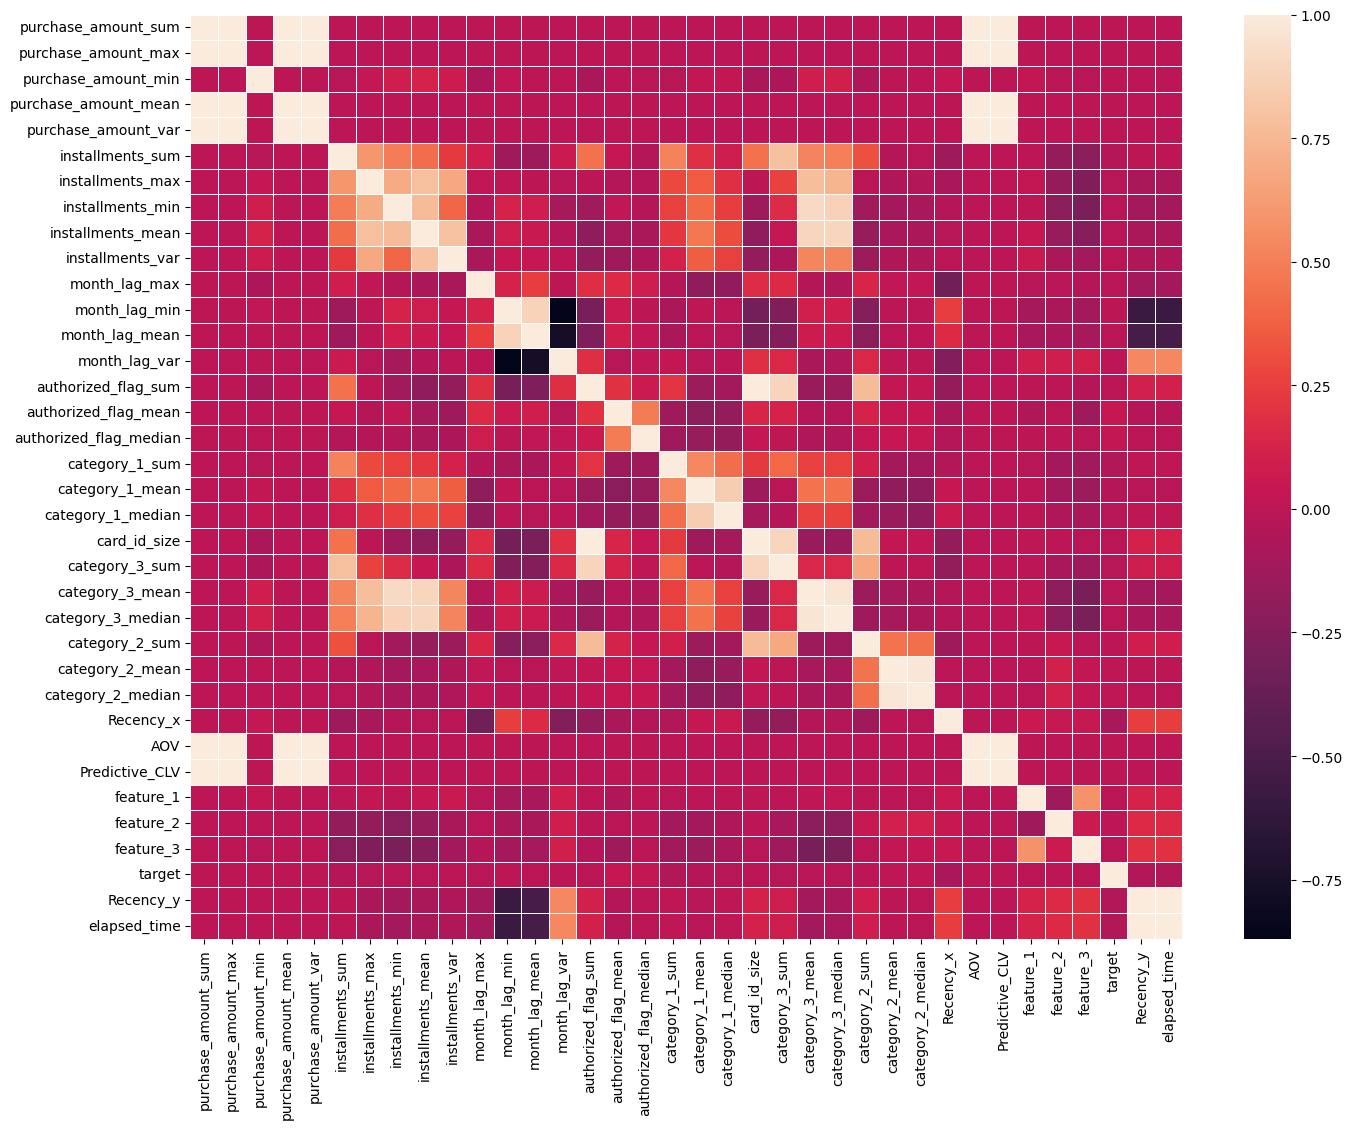

In [73]:
corrmax = df_train_new.corr()

f, ax = plt.subplots(figsize=(16,12))
sns.heatmap(corrmax,  linewidths=.5)

### Training

In [85]:
scaler = StandardScaler()
data=df_train_new.loc[:,~df_train_new.columns.isin(['card_id','first_active_month','purchase_date_max','purchase_date_min'])]
scaled=scaler.fit_transform(data)

X=pd.DataFrame(scaled,columns=data.columns)

In [86]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

y = X['target']

X =X.loc[:,~X.columns.isin(['target','card_id','first_active_month','purchase_date_max','purchase_date_min'])]

X = my_imputer.fit_transform(X)

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=6)

In [88]:
from sklearn.ensemble import RandomForestRegressor

reg_predictions = []

In [89]:
myRandomForestReg = RandomForestRegressor(n_estimators = 9, bootstrap = True, random_state = 3)

myRandomForestReg.fit(X_train, y_train)

y_predict_myRandomForestReg = myRandomForestReg.predict(X_test)

reg_predictions.append(y_predict_myRandomForestReg)

In [90]:
from sklearn import metrics

for model, y_prediction in zip([ 'Random Forest: '], reg_predictions):
    mse = metrics.mean_squared_error(y_test, y_prediction)
    rmse = np.sqrt(mse)
    print(model + str(rmse))

Random Forest: 1.0561648007533004


### XGBoost

In [91]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [92]:
model = XGBRegressor()

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

xgb_model =XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)

print(np.sqrt(mse))

[10:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
0.9949770673754004
